In [1]:
##This kernel will help beginners to make themselves familiar with the Time Series Analysis in Python
## Dataset is avalable on kaggle https://www.kaggle.com/code/chirag19/time-series-analysis-with-python-beginner/notebook
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

In [2]:
##Import the data
data = pd.read_csv('AirPassengers.csv')

In [3]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
data.dtypes

Month          object
#Passengers     int64
dtype: object

In [5]:
data['Month'] = pd.to_datetime(data["Month"])
data.set_index(data["Month"], drop = True, inplace = True)
data.drop("Month", axis = 1,inplace = True)

In [6]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [7]:
ts = data["#Passengers"]

In [8]:
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [9]:
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

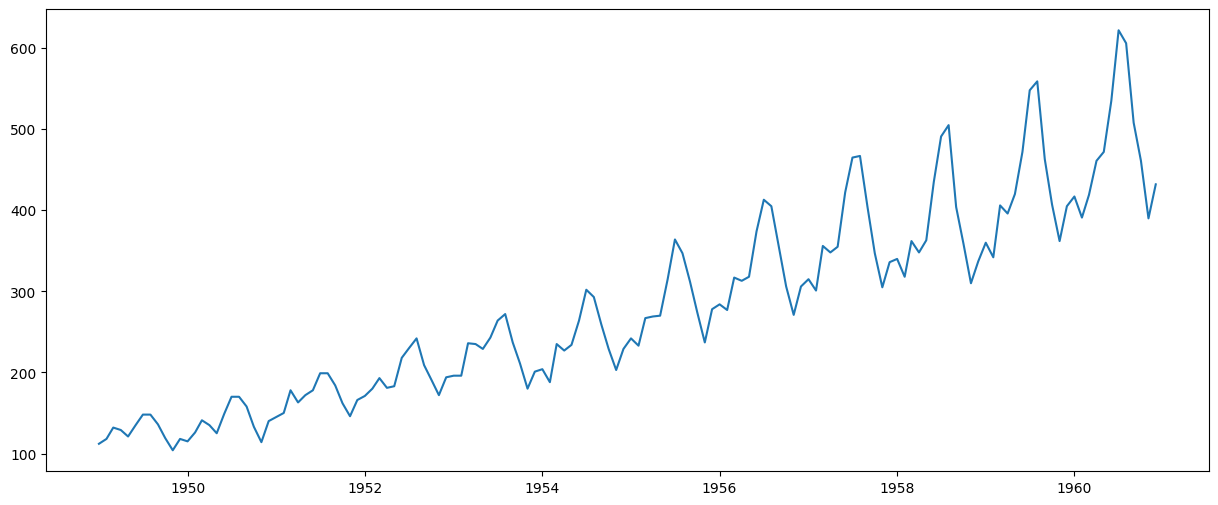

In [10]:
###Check for staionarity of the data
##A Time Series is said to be stationary if the statistical properties (mean, variance) remain constant over time
rcParams['figure.figsize'] = 15,6
plt.plot(ts)

<Axes: ylabel='Density'>

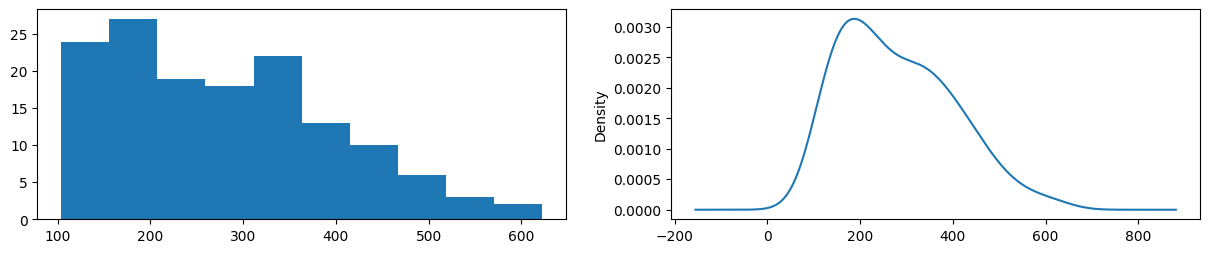

In [11]:
plt.subplot(221)
plt.hist(ts)
plt.subplot(222)
ts.plot(kind = 'kde')

In [12]:
###Dickey-Fuller Test to test for stationarity
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, roll_window):
    ##Determine rolling statistics
    rolmean = timeseries.rolling(window = roll_window).mean()
    rolstd = timeseries.rolling(window = roll_window).std()
    
    ##Plotting rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling STD')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()
    
    ##Dickey fuller test
    print("Results of Dickey Fuller Test:")
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags used', 'Number of Observations used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print (dfoutput)

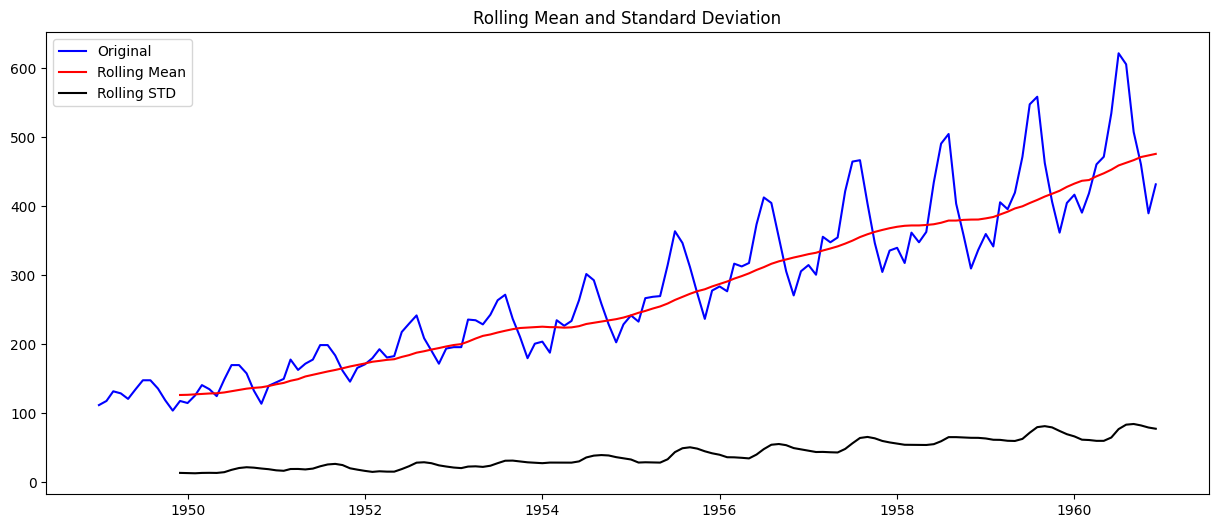

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags used                      13.000000
Number of Observations used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [13]:
test_stationarity(ts, 12)

In [14]:
##From the above, though rolstd is more stable, the rolmean trends upwards. Therefore, the ts is not stationary.
##Also, Test Statiistic >> Critical value (5%), which is further proof

##Therefore, we will have to attempt to make the series stationary
##Non-stationarity is caused by 2 major reasons:
##1. Trend - varying mean over time (see rolling average trending upwards, implying that the mean passengers was growing over time)
##2. Seasonality - variations at specific time frames

##The underlying principle is to model the trend and seasonality and remove these from the series to get a stationary series
##After which, statistical forecasting can be applied to the stationary series, then the trend and seasonality reapplied to get the original scale

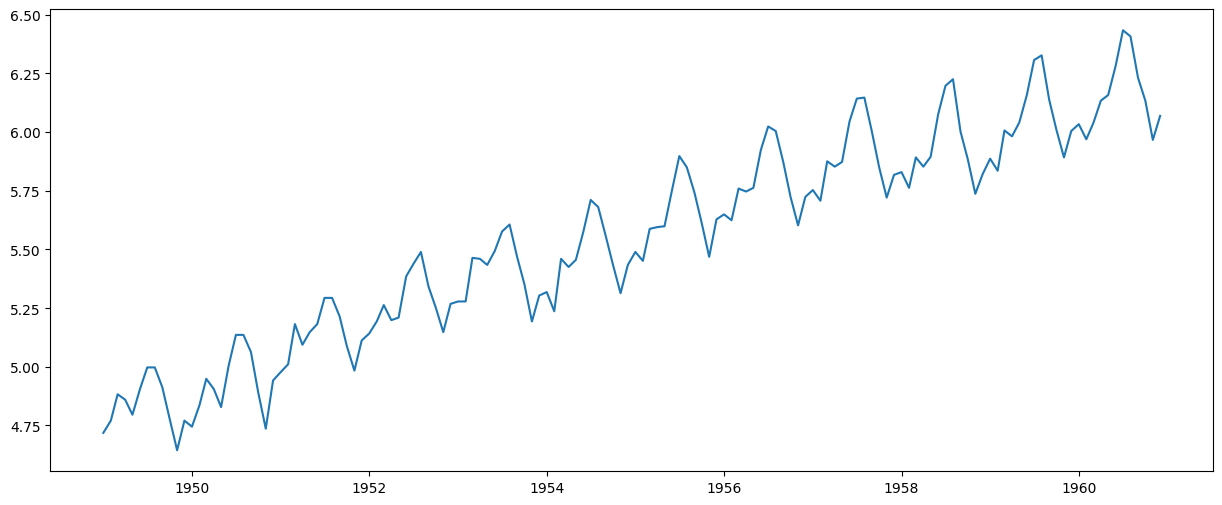

In [15]:
##To model the trend, we first apply a transformation which penalises high values more than small values
##This may be a log transformation, a square root transformation, a cube root transformation etc.
##The log transformation is most popular

ts_log = np.log(ts)
plt.plot(ts_log)

In [16]:
##After transforming, we can see an obvious trend (upward). However, we can still see noisy elements.
##To estimate the trend and then remove its effect, we can use 3 commonly used methods
##1. Aggregation - Taking average for a time period (monthly/weekly averages)
##2. Smoothing - Taking rolling averages
##3. Polynomial fitting - fit a regression model

##Of the 3, Smoothing is the most popular

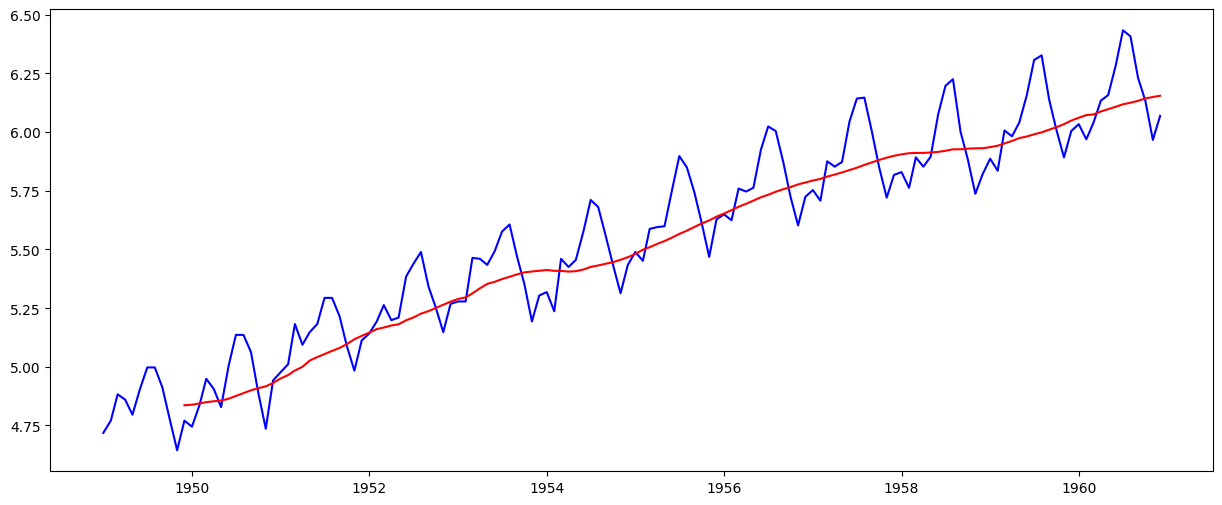

In [17]:
##Inspecting the time series, we can see a seasonality of 12 months (i.e. the series tends to repeat a pattern every 12 months)
##We can therefore choose to roll our transformed time series over 12 months
moving_avg = ts_log.rolling(window =12).mean()
plt.plot(ts_log, color = 'blue')
plt.plot(moving_avg, color = 'red')

In [18]:
##Observe that the rolling average values in the first 11 months are NaN, because our rolling window is set to 12
##Therefore, there won't be any figures till the 12th month

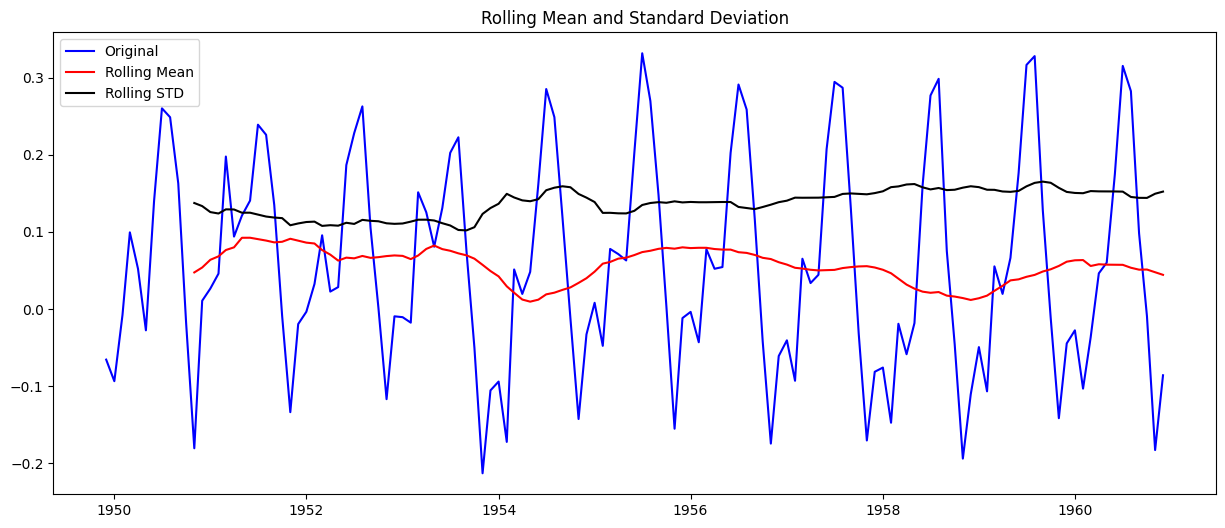

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags used                      13.000000
Number of Observations used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [19]:
#Having determined our trend with smoothing, we can now eliminate the effect of trend from the transformed series and test for stationarity
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(ts_log_moving_avg_diff, 12)

In [20]:
### From the tests above the rolling values, though vary, do not have any identifyable trend.
### Also, the Test Statistic is less than the 5% Critical Value
### Therefore, we can say that the transformed, detrended time series is stationary with 95% confidence

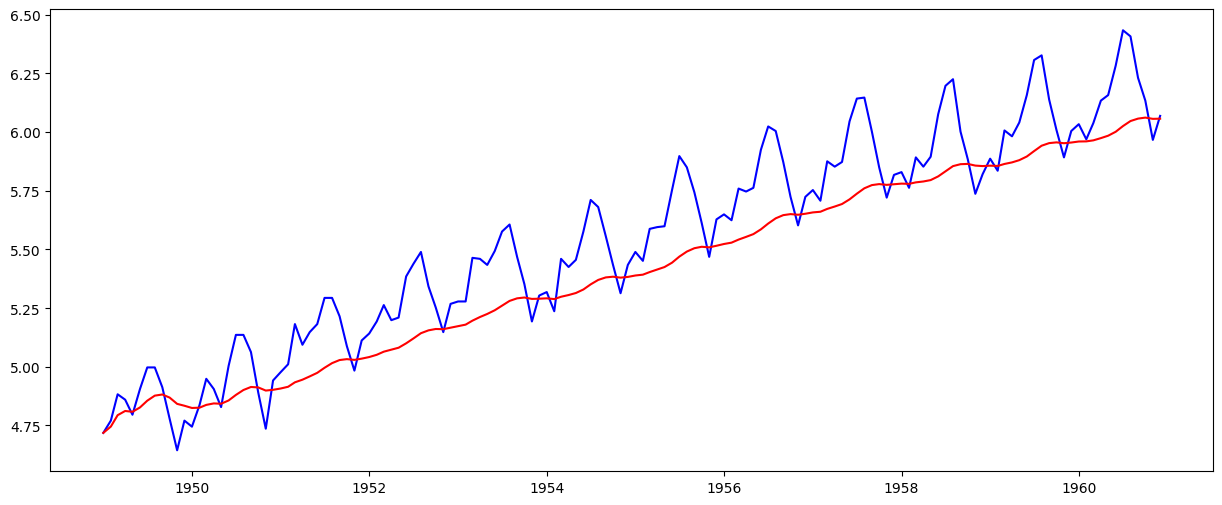

In [21]:
### A drawback to the above approach is that the time-period for the moving average has to be strictly defined
### Here, we deduced that to be 12 months, but in some cases that may not be possible (e.g. stock price predictions)
### So we take a weighted moving average approach, where more recent values are given a higher weight.
### A popular one is the expoonentially weighted moving average, where weights are assigned to all previous values with a decay factor

exp_weighted_avg = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log, color = 'blue')
plt.plot(exp_weighted_avg, color = 'red')

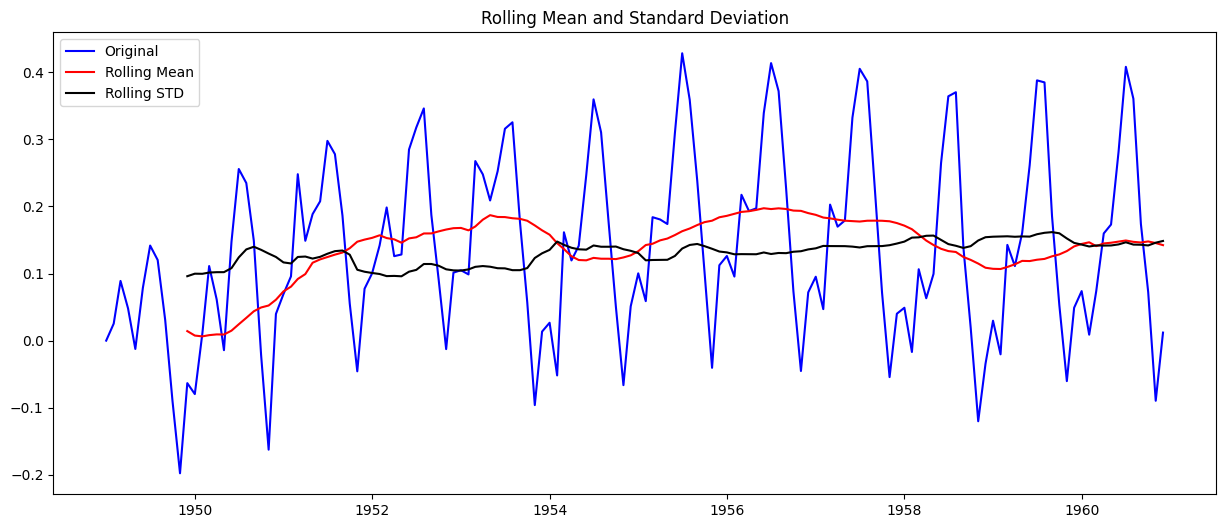

Results of Dickey Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags used                      13.000000
Number of Observations used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [22]:
### We can then eliminate the ewm-average trend from the series and test for stationarity
ts_log_ema_diff = ts_log - exp_weighted_avg
test_stationarity(ts_log_ema_diff, 12)

In [23]:
### From the tests above the rolling values vary even less
### Also, the Test Statistic is less than the 1% Critical Value
### Therefore, we can say that the transformed, detrended time series is stationary with 99% confidence

In [24]:
###Eliminating Trend and Seasonality
## There are two methods to eliminate trend and seasonality
## 1. Differencing
## 2. Decomposing

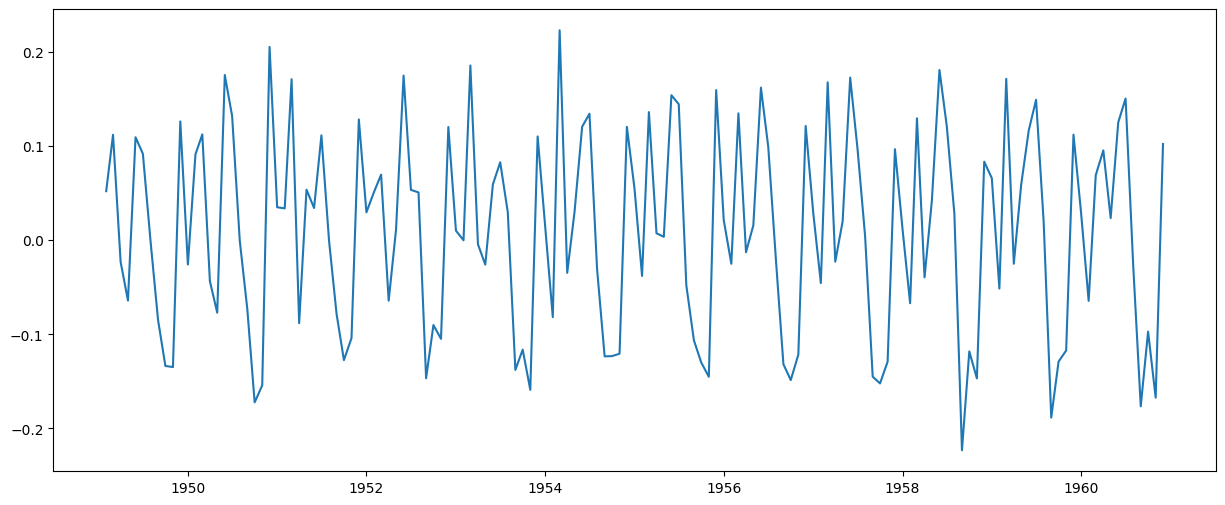

In [25]:
## 1. Differencing
## This works by removing the effect of the previous observation on the current observation
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

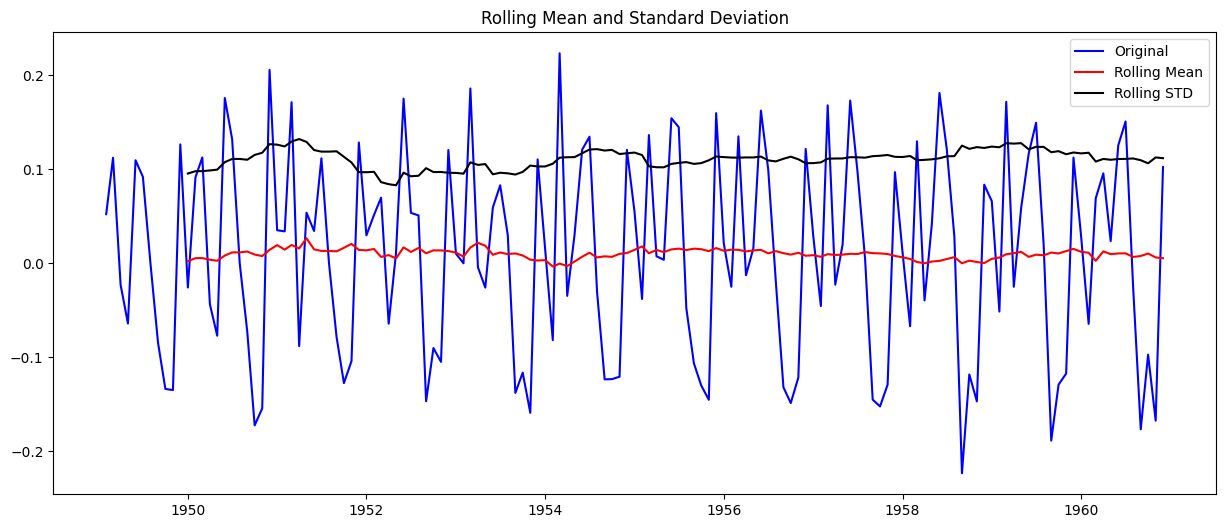

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags used                      14.000000
Number of Observations used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [26]:
##Testing for stationarity of the differenced transformed time series
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff, 12)

In [27]:
### From the tests above there is some variation in the rolling values with time
### Also, the Test Statistic is less than the 10% Critical Value
### Therefore, we can say that the transformed, differenced time series is stationary with 90% confidence

In [28]:
## 2. Decomposing
## When decomposing, the transformed time series is separated into its trend, season and residual components
## Decomposition may be additive (y = x(trend) + x(season) + x(residual)) or multiplicative (y = x(trend) * x(season) * x(residual))

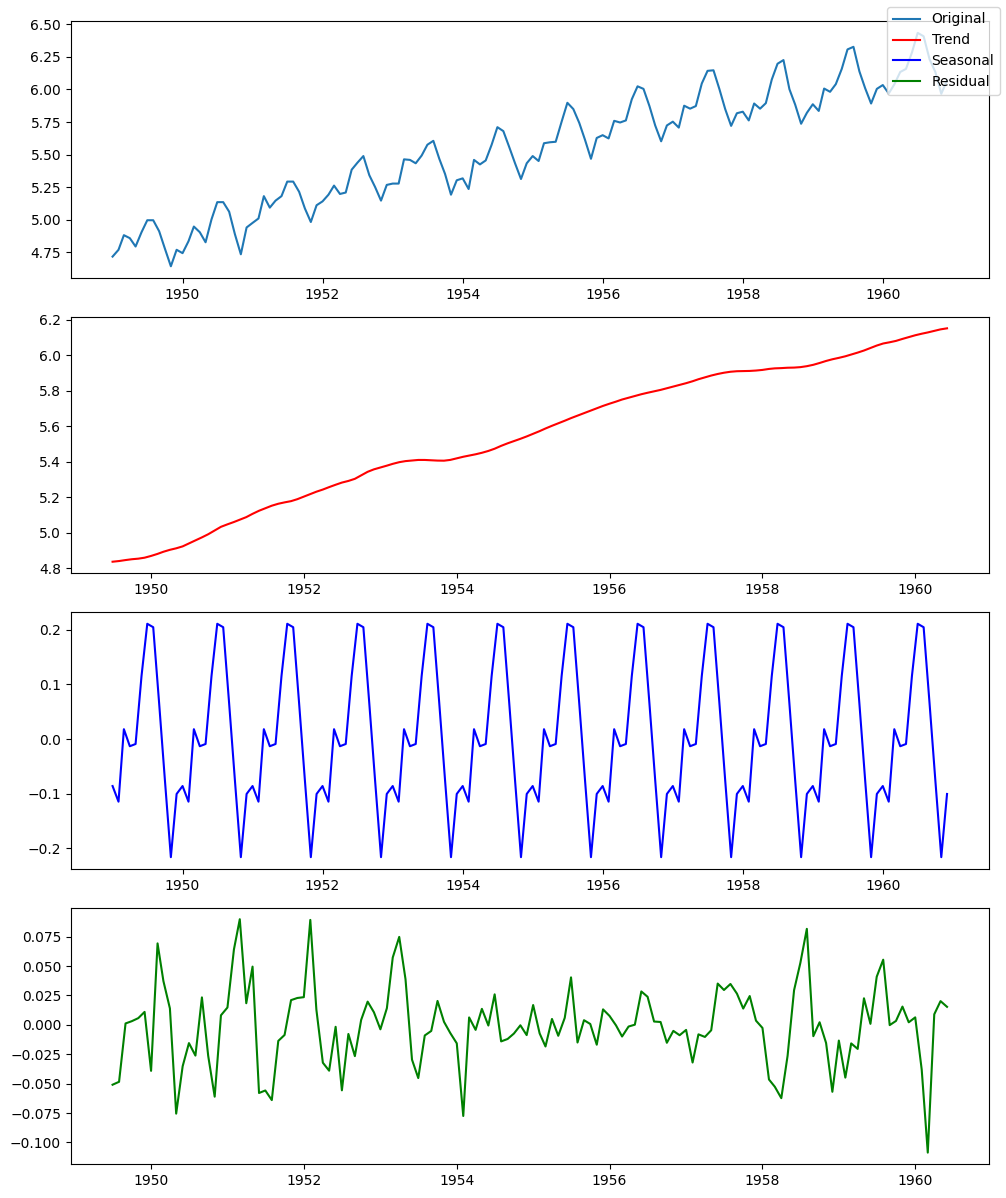

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(ts_log, model = 'additive')
trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid

fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (10,12))
axes[0].plot(ts_log, label = 'Original')
axes[1].plot(trend, label = 'Trend', color = 'red')
axes[2].plot(seasonal, label = 'Seasonal', color = 'blue')
axes[3].plot(residual, label = 'Residual', color = 'green')
fig.tight_layout()
fig.legend()

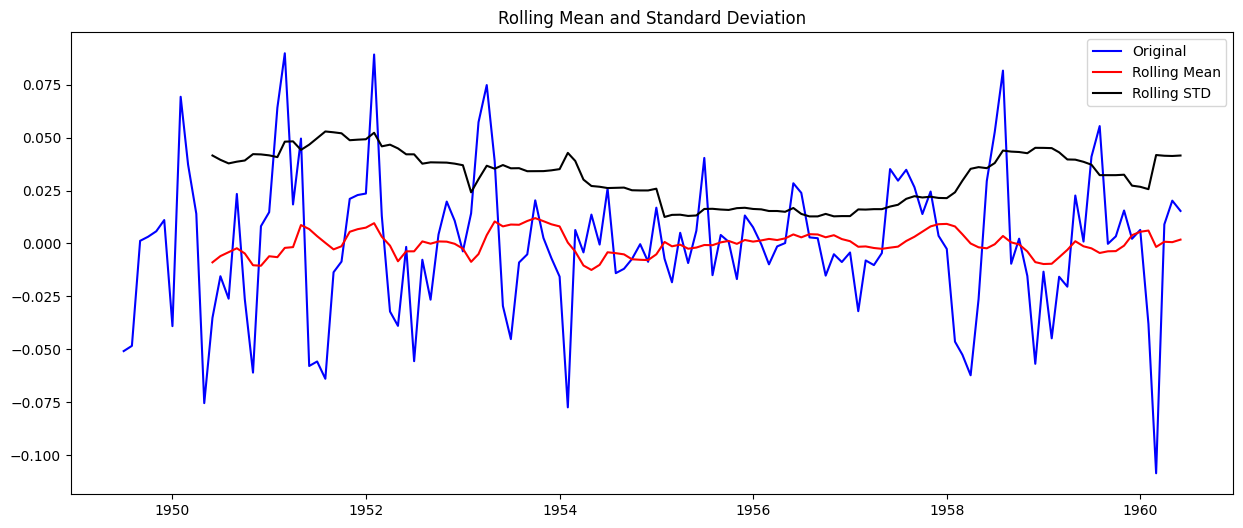

Results of Dickey Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags used                     9.000000e+00
Number of Observations used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [30]:
## The residual component is then analysed and forecasted, then incorporated back into the trend and season and the transformed back
ts_log_decompose = residual
ts_log_decompose.dropna(inplace = True)
test_stationarity(ts_log_decompose, 12)

In [31]:
### From the above, the residual is very close to stationary, with 99% confidence

In [32]:
### FORECASTING THE TIME SERIES
### Forecasting a time series involves predicting the stationary element of a time series, and then retransforming it back to its original scale, adding the seasonality and trend.
## A popular forecasting method is to model the differenced series, as adding trend and seasonality is a matter of cummulative sum and applying reverse transformation (exp, square, cube etc)
## Having performed the trend and seasonality estimation, we can then have two situations
## a. A strictly stationary series with no dependence among the values (this is easy to model but rare)
## b. A series with significant dependence among values (in this case we use ARIMA to model)

In [33]:
## The Auto-Regressive Integrated Moving Average (ARIMA) forecasting is essentially a linear regression. 
## A statistical model is autoregressive if it predicts future values based on past values.
## The ARIMA model gauges the strength of one dependent variable relative to other changing variables
## Its goal is goal is to predict future values by examining the differences between values in the series instead of through actual values.

### Autoregression (AR): refers to a model that shows a changing variable that regresses on its own lagged, or prior, values.
### Integrated (I): represents the differencing of raw observations to allow the time series to become stationary (i.e., data values are replaced by the difference between the data values and the previous values).
### Moving average (MA):  incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations

## The predictors of the regression depend on the parameters of the ARIMA model
## The parameters are:
### The number of Auto-Regressive terms (p)
### The number of Moving Average terms (q)
### The order of differencing (d) (note that for the differenced ts, d = 0, whereas for the original ts, we can set d = 1)

## To determine the parameters p and q, we use the autocorrelation and partial autocorrelation plots
### The autocorrelation plot (acf) is a measure of the correlation between the time series and a lagged version of itself.
### At lag 5, the acf will compare t(1) with t(1-5), t(2) with t(2-5) etc

### The partial autocorrelation plot (pacf) measures the lagged correlations while elimiinating the effects of intervening comparisons.
### For example, at lag 5, it compares the correlation of t(1) with t(1-5) while eliminating the effect of lags 1 through 4

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

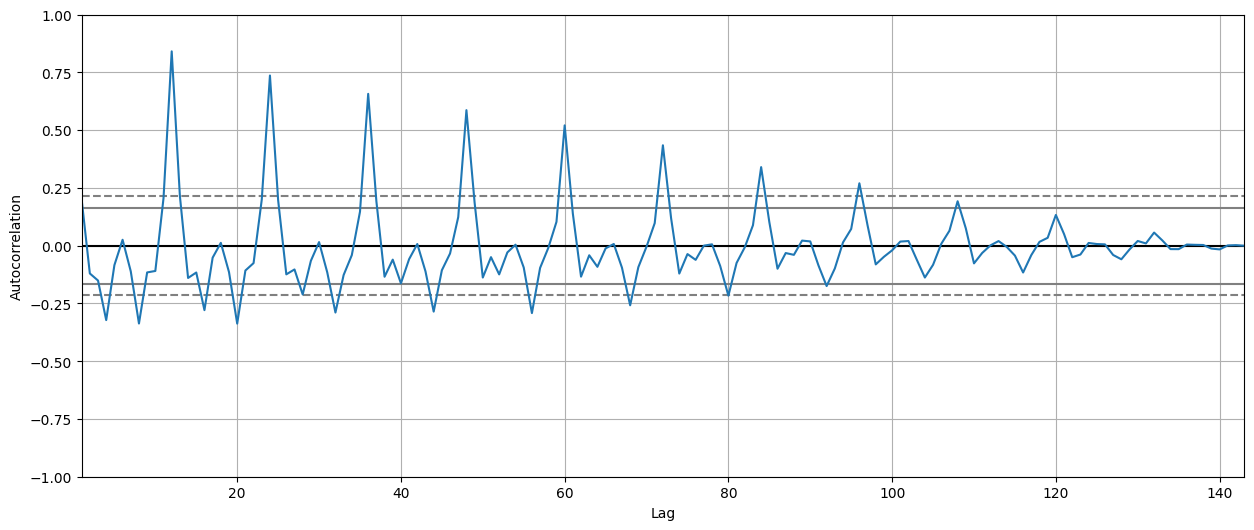

In [34]:
#ACF plot
pd.plotting.autocorrelation_plot(ts_log_diff)

In [35]:
## From the plot above, due to seasonality, at lag 12 the autocorrelation is high
## It is also repeating but progressively attenuated at multiples of 12

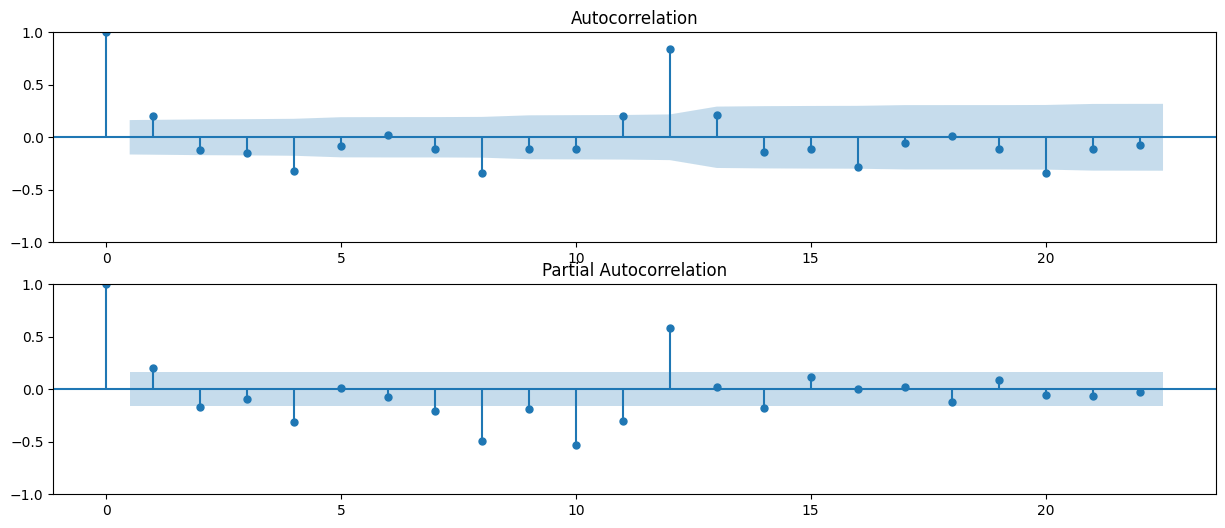

In [36]:
##Plotting the ACF and PACF to get values of p and q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.subplot(211)
plot_acf(ts_log_diff, ax=plt.gca())
plt.subplot(212)
plot_pacf(ts_log_diff, ax=plt.gca())
plt.show()


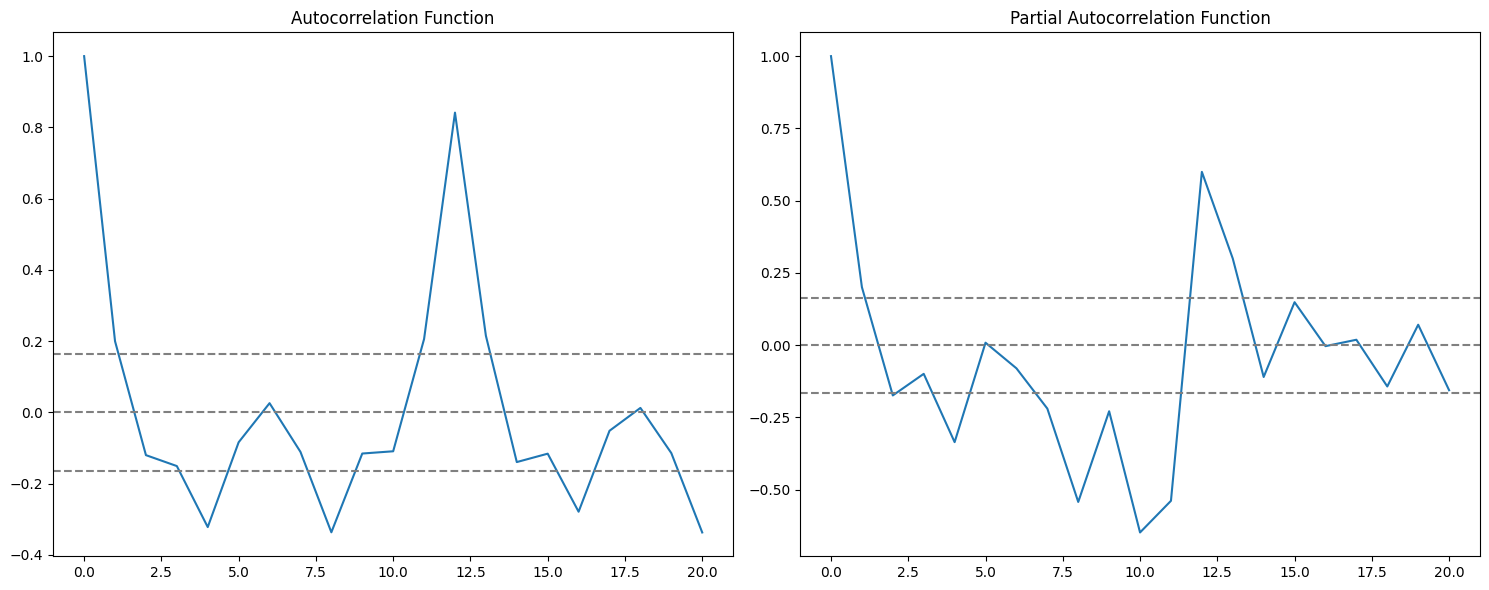

In [37]:
#Another method
#ACF and PACF plots
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags = 20)
lag_pacf = pacf(ts_log_diff, nlags = 20, method = 'ols')


#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray') #Add a horizontal line across the axis at y = 0.
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)), linestyle = '--', color = 'gray') #Lower confidence interval
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)), linestyle = '--', color = 'gray') #Upper confidence interval
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color = 'gray') #Lower confidence interval
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color = 'gray') #Upper confidence interval
plt.title('Partial Autocorrelation Function')
plt.tight_layout() #Automatically adjust subplot parameters to give specified padding.

In [38]:
### From the plots above, the two dotted lines above and below 0 are the confidence intervals
### The values of p and q can be deduced as follows:
## p is the lag value where the PACF chart is most out of the confidence interval for the first time (p = 4)
## q is the number of lag values that are most outside the confidence interval (q = 3)

In [39]:
### We will fit the ARIMA models using values of p,q and d for autoregressive and moving average models
### We will apply the model to the differenced time series, so d = 0
### For the autoregressive model, (p=4,q=0) 
### For the moving average model, (p=0,q=3) 

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS: 1.3299')

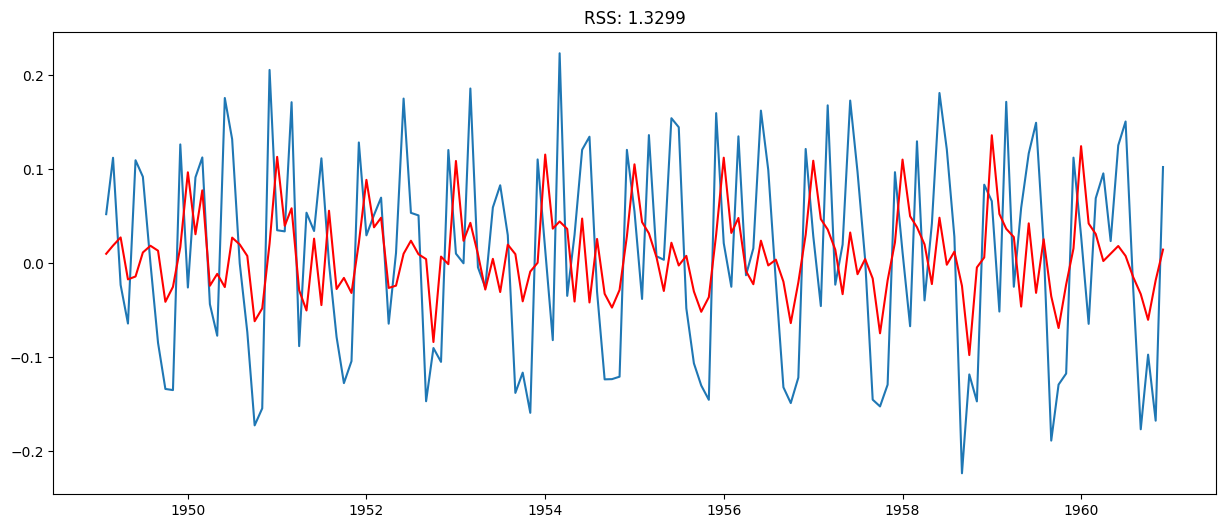

In [40]:
## AR model
### Since we are working with the differenced series (ts_log_diff), we will set d = 0. For AR model, p = 4, q = 0
model = ARIMA(ts_log_diff, order = (4,0,0))
results_AR = model.fit()
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - ts_log_diff)**2)) #Residual sum of squares

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS: 1.2790')

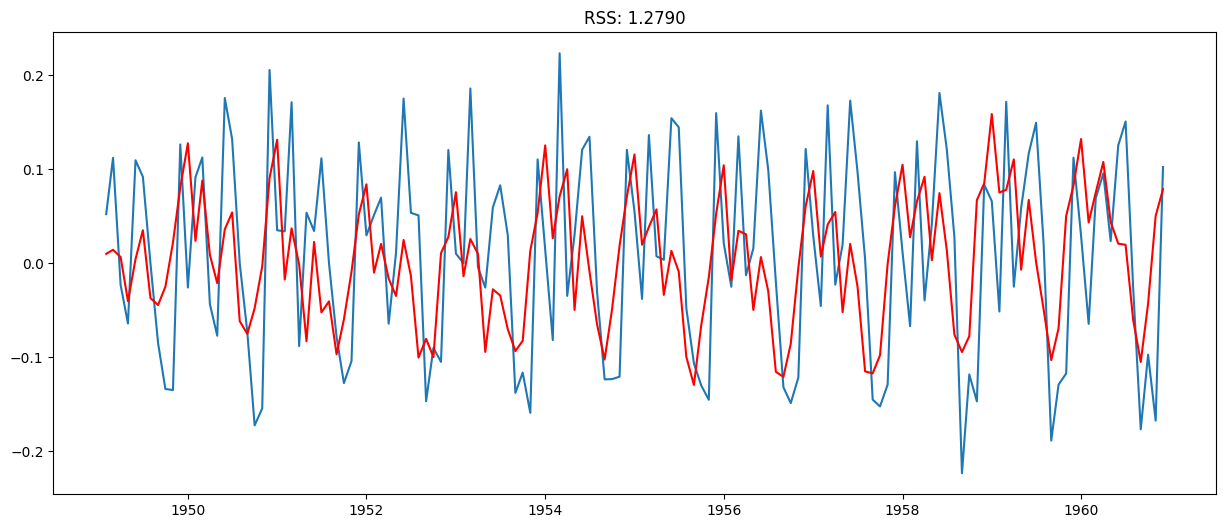

In [41]:
###MA Model
### For MA model, p = 0, q = 3
model = ARIMA(ts_log_diff, order = (0,0,3))
results_MA = model.fit()
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues - ts_log_diff)**2)) #Residual sum of squares

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'RSS: 0.9488')

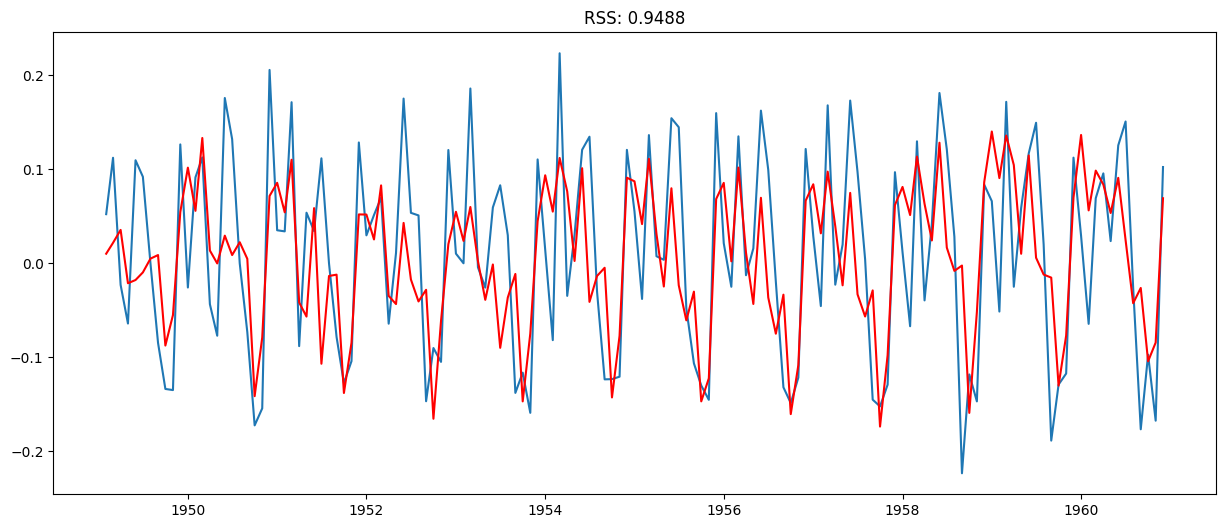

In [42]:
### Combining AR and MA models, p= 4, q= 3
model = ARIMA(ts_log_diff, order = (4,0,3))
results_ARIMA = model.fit()
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - ts_log_diff)**2)) #Residual sum of squares

,predictions,#Passengers
Month,,
1949-02-01,113.144214,118
1949-03-01,115.630316,132
1949-04-01,119.805324,129
1949-05-01,117.290220,121
1949-06-01,115.224941,135
...,...,...
1960-08-01,333.593744,606
1960-09-01,324.959229,508
1960-10-01,292.809086,461


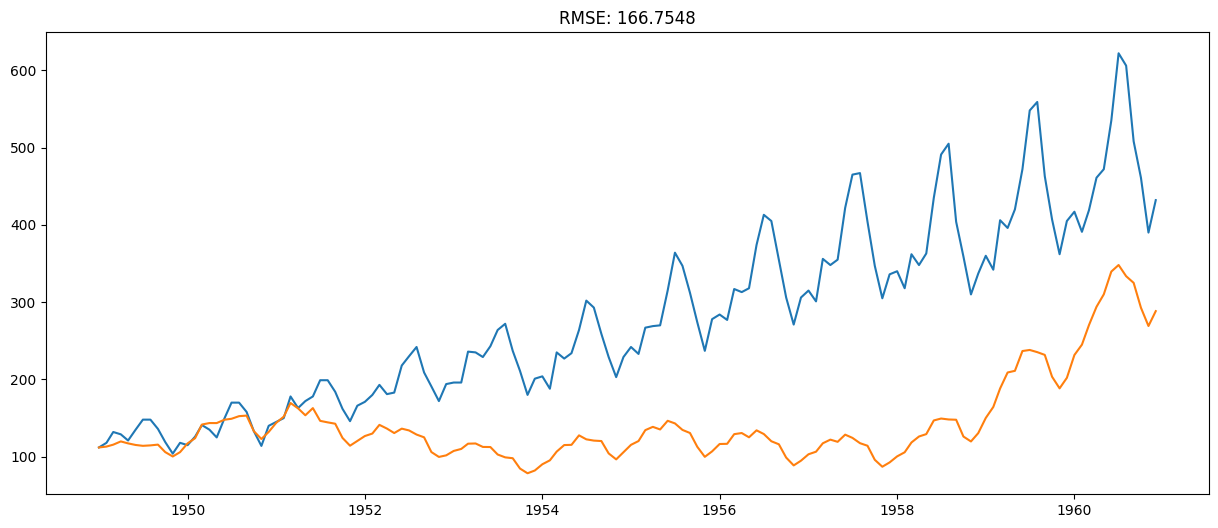

In [43]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

## Reverve the differencing
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

## Reverse the log transform
predictions_ARIMA = np.exp(predictions_ARIMA_log)

##Plot the ARIMA model vs the actual time series
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

### Values of predictions vs actuals
pred_vs_actual = pd.merge(
    pd.DataFrame(data = predictions_ARIMA, index = predictions_ARIMA_diff.index, columns=["predictions"]),
    pd.DataFrame(data = ts, index = ts_log_diff.index), on = "Month")
pred_vs_actual

In [44]:
### We can also use the auto_arima function to determine optimum values of p,q and d
from pmdarima.arima import auto_arima

auto_model = auto_arima(ts_log_diff)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(4, 0, 3)   Log Likelihood                 152.994
Date:                Mon, 04 Dec 2023   AIC                           -287.987
Time:                        21:26:53   BIC                           -261.322
Sample:                    02-01-1949   HQIC                          -277.152
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0120      0.002      7.397      0.000       0.009       0.015
ar.L1          0.3729      0.106      3.521      0.000       0.165       0.580
ar.L2         -0.4150      0.104     -4.005      0.000      -0.618      -0.212
ar.L3          0.4722      0.090      5.261      0.000       0.296       0.648
ar.L4         -0.6201      0.107     -5.777      0.000      -0.830      -0.410
ma.L1         -0.3142      0.120     -2.611      0.009      -0.550      -0.078
ma.L2          0.1574      0.140      1.126      0.260      -0.117       0.431
ma.L3         -0.8050      0.126     -6.408      0.000      -1.051      -0.559
sigma2         0.0067      0.001      5.927      0.000       0.004       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.76   Prob(JB):                         0.48
Heteroskedasticity (H):               1.20   Skew:                             0.13
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
### We can also apply ARIMA to the decomposition method
auto_model = auto_arima(residual)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 288.950
Date:                Mon, 04 Dec 2023   AIC                           -565.901
Time:                        21:26:54   BIC                           -548.604
Sample:                    07-01-1949   HQIC                          -558.872
                         - 06-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    3.04e-05   8.98e-05      0.339      0.735      -0.000       0.000
ar.L1          1.5230      0.098     15.539      0.000       1.331       1.715
ar.L2         -0.7530      0.087     -8.679      0.000      -0.923      -0.583
ma.L1         -1.2420      0.132     -9.406      0.000      -1.501      -0.983
ma.L2          0.2648      0.135      1.960      0.050     4.1e-05       0.530
sigma2         0.0007   8.48e-05      8.590      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   1.47   Jarque-Bera (JB):                 3.61
Prob(Q):                              0.23   Prob(JB):                         0.16
Heteroskedasticity (H):               0.64   Skew:                            -0.22
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS: nan')

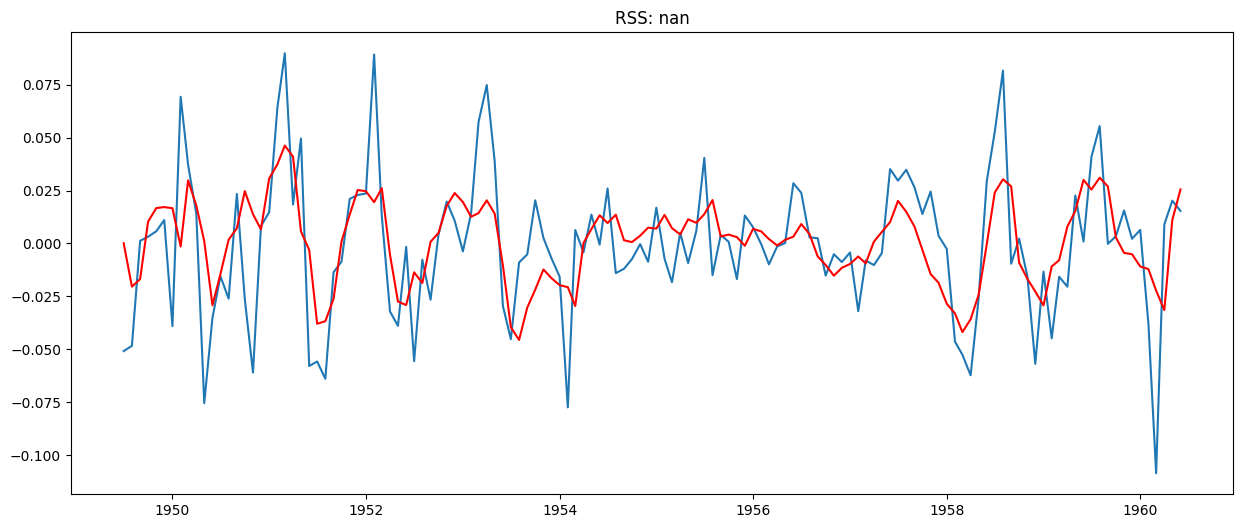

In [50]:
### From here, we can apply ARIMA model with parameters values (2,0,2) on the residual 
model_residual = ARIMA(residual, order = (2,0,2))
results_ARIMA_residual = model_residual.fit()
plt.plot(residual)
plt.plot(results_ARIMA_residual.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_ARIMA_residual.fittedvalues - ts_log_diff)**2))

In [47]:
predictions_ARIMA_residual = results_ARIMA_residual.fittedvalues
pred_vs_act = pd.merge(
    pd.merge(
        pd.merge(
            pd.merge(
                pd.DataFrame(data = ts_log, index = ts_log.index),
                pd.DataFrame(data = predictions_ARIMA_residual, index = predictions_ARIMA_residual.index, columns=["residual_predictions"]),
                on = "Month", how = "left"),
            trend, 
            on="Month", how = "left"), 
        seasonal, 
        on="Month", how = "left"),
    residual, 
    on = "Month", how = "left")

pred_vs_act["simulated"] = pred_vs_act["residual_predictions"]+pred_vs_act["seasonal"]+pred_vs_act["trend"]
pred_vs_act


,#Passengers,residual_predictions,trend,seasonal,resid,simulated
Month,,,,,,
1949-01-01,4.718499,NaN,NaN,-0.085815,NaN,NaN
1949-02-01,4.770685,NaN,NaN,-0.114413,NaN,NaN
1949-03-01,4.882802,NaN,NaN,0.018113,NaN,NaN
1949-04-01,4.859812,NaN,NaN,-0.013046,NaN,NaN
1949-05-01,4.795791,NaN,NaN,-0.008966,NaN,NaN
...,...,...,...,...,...,...
1960-08-01,6.406880,NaN,NaN,0.204512,NaN,NaN
1960-09-01,6.230481,NaN,NaN,0.064836,NaN,NaN
1960-10-01,6.133398,NaN,NaN,-0.075271,NaN,NaN


<Axes: xlabel='Month'>

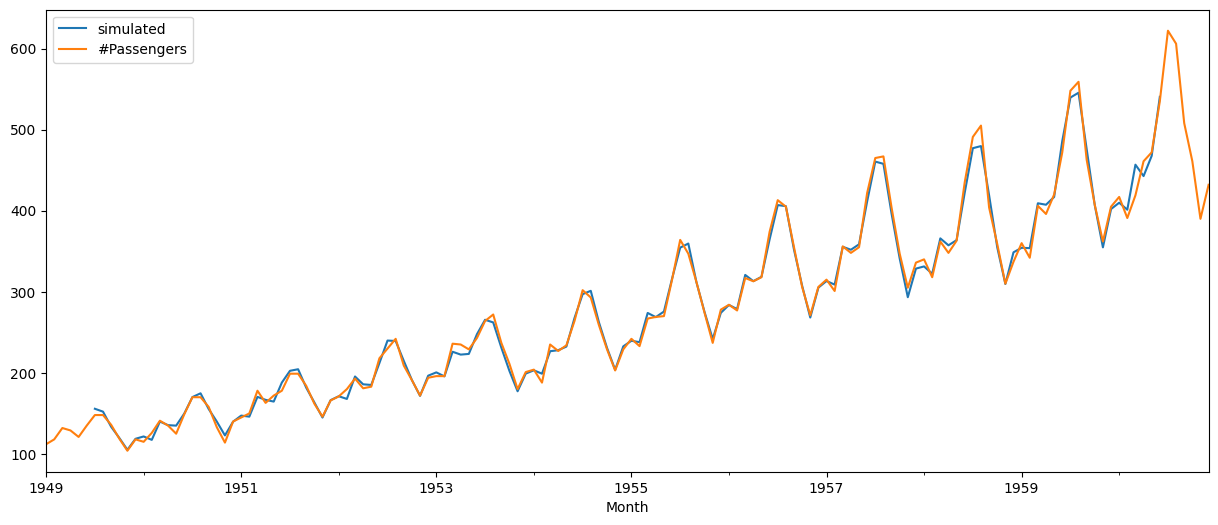

In [51]:
### Reverse the log transform and plot the simulated predictions vs the actual passengers
np.exp(pred_vs_act[["simulated", "#Passengers"]]).plot()

In [53]:
### FORECASTING USING SARIMAX
### Seasonal Autoregressive Integrated Moving Average (SARIMA) attempts to model seasonal time series using additional seasonal parameters.
### The seasonal parameters are denoted P, D, Q, S
import itertools
p = d = q = range(2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [80]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

AIC_df = pd.DataFrame(data={}, columns = ['params', 'seasonal_params', 'AIC'])

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_log, order = param, 
                                            seasonal_order = seasonal_param, 
                                            enforce_stationarity = False, 
                                            enforce_invertibility = False)
            results = mod.fit()
            temp = pd.DataFrame(data = [[param, seasonal_param, results.aic]], columns = ['params', 'seasonal_params', 'AIC'])
            AIC_df = pd.concat([temp,AIC_df])
            #del temp
        except:
            continue
AIC_df.reset_index(inplace=True,drop = True)

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11367D+00    |proj g|=  3.49036D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   4.254D-08   3.114D+00
  F =   3.1136692662642318     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.3


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -8.83411D-01    |proj g|=  1.50330D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     22      1     0     0   1.687D-05  -8.834D-01
  F = -0.88341082211713218     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42091D+00    |proj g|=  1.64274D-01
  ys=-2.739E+01  -gs= 8.952E-01 BFGS update SKIPPED

At iterate    5    f= -1.29779D+00    |proj g|=  3.01404D+01

At iterate   10  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.70069D-01    |proj g|=  4.52848D+00

At iterate    5    f= -1.10740D+00    |proj g|=  1.70317D+00

At iterate   10    f= -1.19406D+00    |proj g|=  8.76900D-01

At iterate   15    f= -1.20659D+00    |proj g|=  1.17846D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     32      1     0     0   6.306D-04  -1.207D+00
  F =  -1.2065947492874445     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.46378D+00    |proj g|=  5.65921D-01

At iterate   10    f= -1.47653D+00    |proj g|=  1.70878D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     18      1     0     0   1.685D-04  -1.478D+00
  F =  -1.4777697254512170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53261D+00    |proj g|=  4.51368D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.27250D-01    |proj g|=  1.76652D-01

At iterate    5    f= -8.27891D-01    |proj g|=  2.58541D-01

At iterate   10    f= -8.28257D-01    |proj g|=  4.23063D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     13      1     0     0   4.231D-05  -8.283D-01
  F = -0.82825679321214818     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.50689D+00    |proj g|=  1.20033D+00

At iterate   10    f= -1.51568D+00    |proj g|=  7.04212D-02

At iterate   15    f= -1.51615D+00    |proj g|=  6.55803D-01

At iterate   20    f= -1.51661D+00    |proj g|=  3.13584D-01

At iterate   25    f= -1.51691D+00    |proj g|=  4.82994D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     37      1     0     0   3.512D-04  -1.517D+00
  F =  -1.5169085494978354     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.38551D+00    |proj g|=  4.44906D-01

At iterate   10    f= -1.44896D+00    |proj g|=  5.21243D+00

At iterate   15    f= -1.49409D+00    |proj g|=  5.18546D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     30      1     0     0   2.178D-04  -1.494D+00
  F =  -1.4940982844697428     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11735D+00    |proj g|=  6.94265D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.39791D+00    |proj g|=  6.20205D+00

At iterate   20    f= -1.46104D+00    |proj g|=  9.74043D-02

At iterate   25    f= -1.46105D+00    |proj g|=  2.13802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     38      1     0     0   1.774D-03  -1.461D+00
  F =  -1.4610509808400949     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30795D+00    |proj g|=  2.67182D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.54361D+00    |proj g|=  2.08510D-01

At iterate   20    f= -1.54494D+00    |proj g|=  3.18031D-02

At iterate   25    f= -1.54495D+00    |proj g|=  1.23012D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     37      1     0     0   1.230D-03  -1.545D+00
  F =  -1.5449465561414628     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11081D+00    |proj g|=  6.59972D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -1.69312D+00    |proj g|=  2.50590D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     64      1     0     0   2.506D-04  -1.693D+00
  F =  -1.6931228588082219     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.62810D-01    |proj g|=  2.12573D+01

At iterate    5    f= -1.12035D+00    |proj g|=  4.33933D-01

At iterate   10    f= -1.24198D+00    |proj g|=  7.59188D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.38918D+00    |proj g|=  3.26540D-01

At iterate   10    f= -1.46991D+00    |proj g|=  2.45974D+00

At iterate   15    f= -1.47326D+00    |proj g|=  1.81748D-01

At iterate   20    f= -1.48660D+00    |proj g|=  2.52253D+00

At iterate   25    f= -1.52467D+00    |proj g|=  1.08311D-01

At iterate   30    f= -1.53307D+00    |proj g|=  1.61178D-01

At iterate   35    f= -1.53324D+00    |proj g|=  4.46177D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     51      1     0     0   5.009D-03  -1.533D+00
  F =  -1.5332367734560934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   9.012D-04  -8.271D-01
  F = -0.82708367452316178     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.52094D-01    |proj g|=  4.05106D+00

At iterate    5    f= -1.02775D+00    |proj g|=  2.10040D-01

At iterate   10    f= -1.04569D+00    |proj g|=  1.77411D+00

At iterate   15    f= -1.05054D+00    |proj g|=  8.39316D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11113D+00    |proj g|=  6.76780D+00

At iterate    5    f= -1.45598D+00    |proj g|=  2.24774D+00

At iterate   10    f= -1.53139D+00    |proj g|=  4.66365D-01

At iterate   15    f= -1.56333D+00    |proj g|=  2.56182D+00

At iterate   20    f= -1.56917D+00    |proj g|=  4.42521D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     31      1     0     0   3.895D-04  -1.569D+00
  F =  -1.5691677312849102     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.51731D+00    |proj g|=  1.13991D+00

At iterate   10    f= -1.51937D+00    |proj g|=  1.61899D-02

At iterate   15    f= -1.51979D+00    |proj g|=  9.04937D-02

At iterate   20    f= -1.52006D+00    |proj g|=  2.04247D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     35      1     0     0   1.314D-03  -1.520D+00
  F =  -1.5200613121971529     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   35    f= -1.06659D+00    |proj g|=  1.83356D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     61      1     0     0   1.834D-05  -1.067D+00
  F =  -1.0665942224345355     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54560D+00    |proj g|=  2.60624D-01

At iterate    5    f= -1.54564D+00    |proj g|=  6.93761D-02

At iterate   10    f= -1.54567D+00    |proj g|=  8.25281D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f= -1.63856D+00    |proj g|=  2.04741D+00

At iterate   10    f= -1.66149D+00    |proj g|=  3.15812D-02

At iterate   15    f= -1.66222D+00    |proj g|=  2.13471D-02

At iterate   20    f= -1.66239D+00    |proj g|=  1.60309D-02

At iterate   25    f= -1.66797D+00    |proj g|=  6.13831D-02

At iterate   30    f= -1.67060D+00    |proj g|=  2.65956D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     73      2     0     0   1.466D-03  -1.671D+00
  F =  -1.6706009439049843     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.52597D+00    |proj g|=  4.01363D-03

At iterate   35    f= -1.52597D+00    |proj g|=  6.52886D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     52      1     0     0   6.529D-03  -1.526D+00
  F =  -1.5259720771690513     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.48887D+00    |proj g|=  4.34225D+00

At iterate    5    f= -1.50735D+00    |proj g|=  1.44537D+00

At iter

In [81]:
AIC_df

,params,seasonal_params,AIC
0,"(1, 1, 1)","(1, 1, 1, 12)",-427.034552
1,"(1, 1, 1)","(1, 1, 0, 12)",-431.479958
2,"(1, 1, 1)","(1, 0, 1, 12)",-471.133072
3,"(1, 1, 1)","(1, 0, 0, 12)",-444.736922
4,"(1, 1, 1)","(0, 1, 1, 12)",-433.785147
...,...,...,...
59,"(0, 0, 0)","(1, 0, 0, 12)",-344.536297
60,"(0, 0, 0)","(0, 1, 1, 12)",-179.241230
61,"(0, 0, 0)","(0, 1, 0, 12)",-150.625773
62,"(0, 0, 0)","(0, 0, 1, 12)",687.374902


In [82]:
### Best selection of parameters is when AIC is least
min_aic = AIC_df.sort_values(by = "AIC").iloc[0]

In [83]:
min_aic

params                 (1, 0, 1)
seasonal_params    (1, 0, 1, 12)
AIC                  -477.619383
Name: 18, dtype: object

In [86]:
model = sm.tsa.statespace.SARIMAX(ts_log, order = min_aic["params"], 
                                  seasonal_order= min_aic["seasonal_params"], 
                                  enforce_invertibility= False,
                                 enforce_stationarity=False)
results = model.fit()
print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11604D+00    |proj g|=  6.86654D+00

At iterate    5    f= -1.50119D+00    |proj g|=  3.52957D+00

At iterate   10    f= -1.56166D+00    |proj g|=  5.54615D+00

At iterate   15    f= -1.68085D+00    |proj g|=  1.86989D+00

At iterate   20    f= -1.68629D+00    |proj g|=  5.13259D-01

At iterate   25    f= -1.69212D+00    |proj g|=  1.42451D-01

At iterate   30    f= -1.69230D+00    |proj g|=  2.69197D-01

At iterate   35    f= -1.69302D+00    |proj g|=  2.52999D-01

At iterate   40    f= -1.69312D+00    |proj g|=  1.43428D-02

At iterate   45    f= -1.69312D+00    |proj g|=  2.50590D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


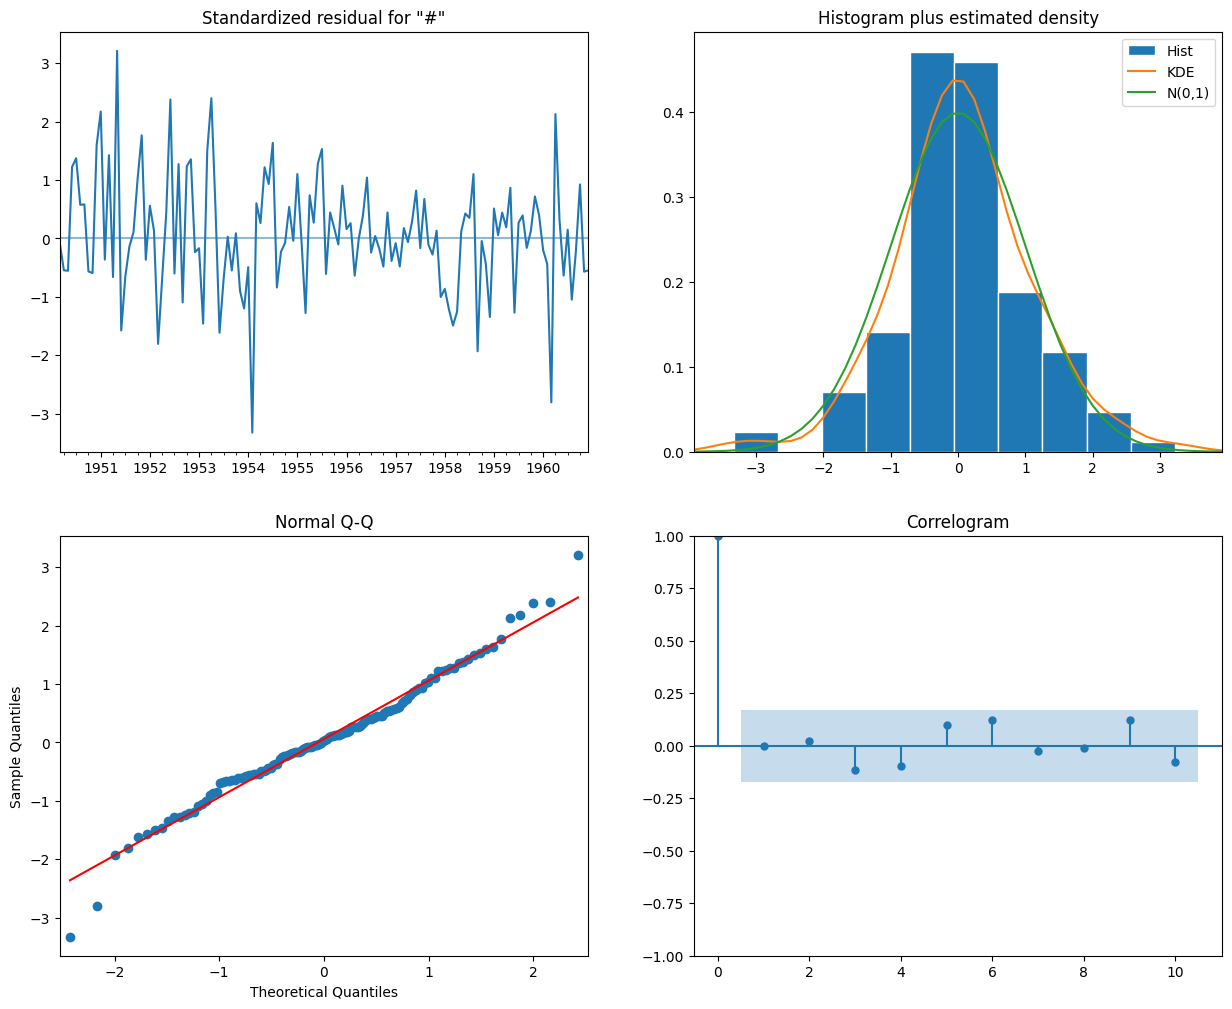

In [87]:
## Plotting the diagnostics of the model results, we get the following
results.plot_diagnostics(figsize = (15,12))
plt.show()

In [88]:
## The aim of the diagnostic is to verify that the residuals are uncorrelated and normally distributed with zero mean
## 1. From the histogram and density estimate, we see that the residuals are normally distributed, and follow a standard normal distribution with mean 0 and stdev 1 (N(0,1))
## 2. The Normal Q-Q plot shows that the ordered distribution of residuals (blue dots) follow the linear trend of a normal distribution N(0,1)
## 3. From the Standardized Residuals plot, the residuals do not show any obvious seasonality or trend
## 4. The Correlalogram, which is the autocorrelation plot, shows that the residuals have low correlation with lagged versions of itself

In [89]:
##Validating forecasts
pred = results.get_prediction(start = pd.to_datetime("1958-01-01"), dynamic = False)
## Get confifence intervals
pred_ci = pred.conf_int()
pred_ci.head()

,lower #Passengers,upper #Passengers
1958-01-01,5.789094,5.931722
1958-02-01,5.734891,5.877518
1958-03-01,5.874630,6.017254
1958-04-01,5.826373,5.968996
1958-05-01,5.818791,5.961414


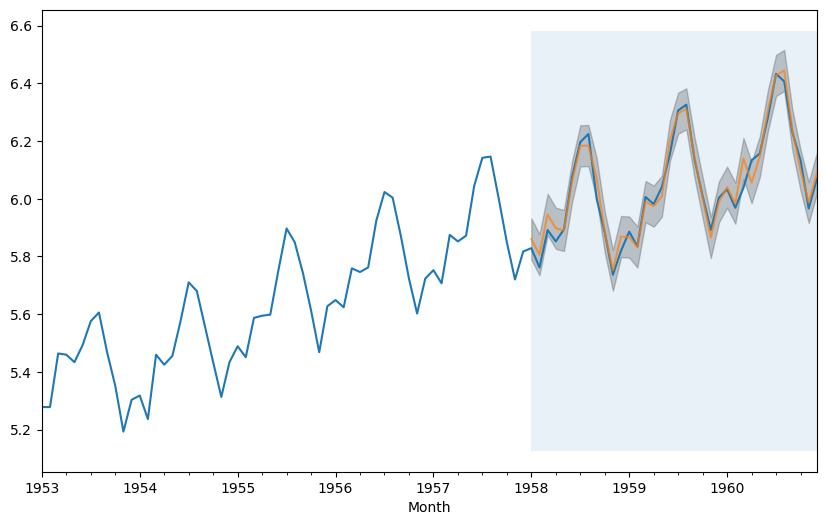

In [97]:
###Now we plot the predictions against the series for date range from 1958
fig, axes = plt.subplots(1,1,figsize =(10,6))
ts_log["1953":].plot(ax = axes)
pred.predicted_mean.plot(ax = axes, label = "One Step ahead forecast", alpha = 0.7)
axes.fill_between(pred_ci.index, pred_ci["lower #Passengers"],pred_ci["upper #Passengers"], color = 'k', alpha = 0.2)
axes.fill_betweenx(axes.get_ylim(), pred_ci.index[0], ts_log.index[-1], alpha = 0.1, zorder = -1)

In [99]:
##To determine the accuracy of our model, we can get the MSE
ts_log_forecasted = pred.predicted_mean
ts_log_original = ts_log["1958":]
mse = ((ts_log_forecasted - ts_log_original)**2).mean()
print("Mean Square Error: {}".format(round(mse,3)))

Mean Square Error: 0.001


In [100]:
### An MSE of 0.001 is very good.
### However, we can get a more accurate model by using dynamic forecasts

Mean Square Error: 0.008


,lower #Passengers,upper #Passengers
1958-01-01,5.789094,5.931722
1958-02-01,5.742084,5.905663
1958-03-01,5.897313,6.077450
1958-04-01,5.870386,6.064032
1958-05-01,5.878688,6.083574


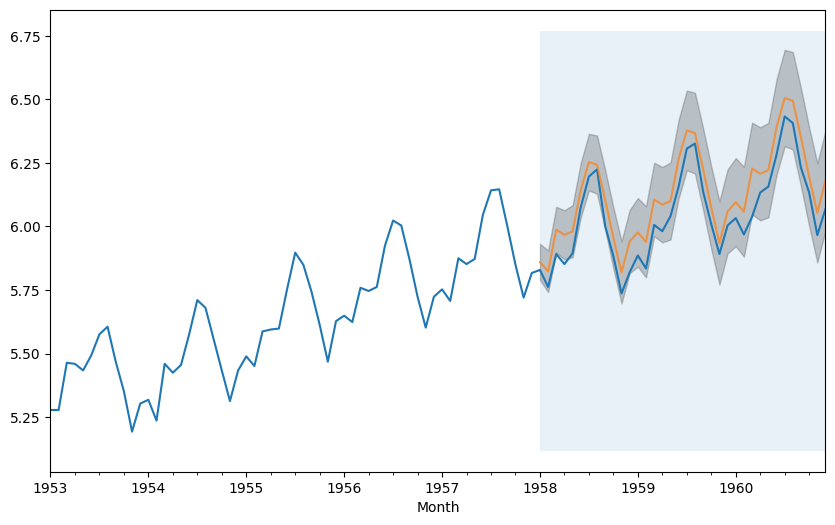

In [104]:
##Validating forecasts
pred_dynamic = results.get_prediction(start = pd.to_datetime("1958-01-01"), dynamic = True, full_results = True)
## Get confifence intervals
pred_dynamic_ci = pred_dynamic.conf_int()


###Now we plot the predictions against the series for date range from 1958
fig, axes = plt.subplots(1,1,figsize =(10,6))
ts_log["1953":].plot(ax = axes)
pred_dynamic.predicted_mean.plot(ax = axes, label = "Dynamic Forecasts", alpha = 0.7)
axes.fill_between(pred_dynamic_ci.index, pred_dynamic_ci["lower #Passengers"],pred_dynamic_ci["upper #Passengers"], color = 'k', alpha = 0.2)
axes.fill_betweenx(axes.get_ylim(), pred_dynamic_ci.index[0], ts_log.index[-1], alpha = 0.1, zorder = -1)

##To determine the accuracy of our model, we can get the MSE
ts_log_forecasted = pred_dynamic.predicted_mean
ts_log_original = ts_log["1958":]
mse = ((ts_log_forecasted - ts_log_original)**2).mean()
print("Mean Square Error: {}".format(round(mse,3)))

pred_dynamic_ci.head()

In [105]:
## Producing and visualising forecasts
pred_uc = results.get_forecast(steps=100)     #Get forecast 100 steps ahead in future (ts_log)
pred_ci = pred_uc.conf_int()                  #Get confidence intervals of forecasts (ts_log)
pred_ci.head()

,lower #Passengers,upper #Passengers
1961-01-01,6.045087,6.187708
1961-02-01,5.978742,6.142314
1961-03-01,6.097811,6.277942
1961-04-01,6.119977,6.313617
1961-05-01,6.151024,6.355905


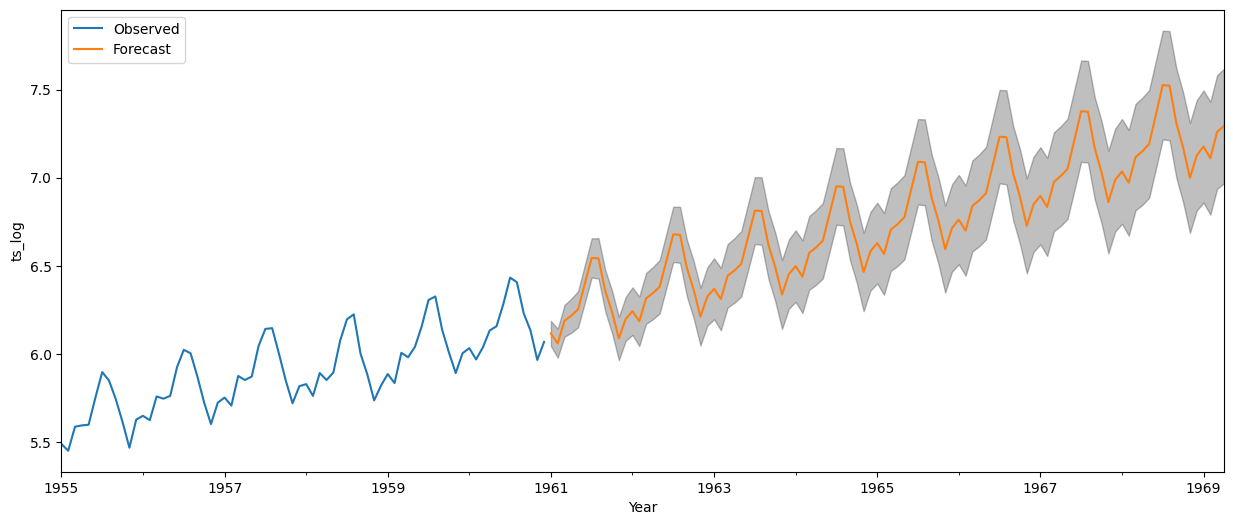

In [106]:
ax = ts_log['1955':].plot(label='Observed')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('ts_log')
plt.legend(loc = 'upper left')
plt.show()

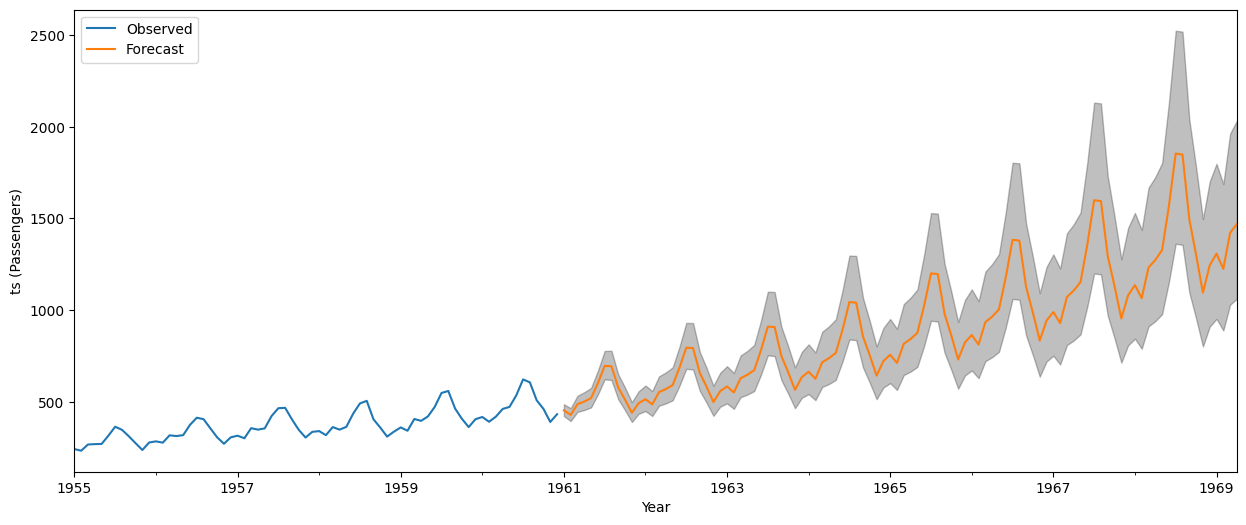

In [107]:
### We have been operating on the transformed time series
###Therefore, to report our predictions, we have to reverse the transformation

pred_uc = np.exp(pred_uc.predicted_mean)
pred_ci = np.exp(pred_ci)

#Plot original data prediction
ax = ts['1955':].plot(label='Observed')
pred_uc.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('ts (Passengers)')
plt.legend(loc = 'upper left')
plt.show()